## Fine-Tune Llama 2 Model for Early Exit
- Follow the blog [Fine-Tune Your Own Llama 2 Model in a Colab Notebook](https://mlabonne.github.io/blog/posts/Fine_Tune_Your_Own_Llama_2_Model_in_a_Colab_Notebook.html) in detail.
- [Fine_tune_Llama_2_in_Google_Colab.ipynb](https://github.com/mlabonne/llm-course/blob/main/Fine_tune_Llama_2_in_Google_Colab.ipynb) <a href="https://colab.research.google.com/github/mlabonne/llm-course/blob/main/Fine_tune_Llama_2_in_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
# !pip install accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 ipywidgets

In [2]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import get_peft_model, LoraConfig, PeftModel
from trl import SFTTrainer

In [3]:
# The model that you want to train from the Hugging Face hub
model_name = "meta-llama/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "yahma/alpaca-cleaned"

# Fine-tuned model name
new_model = "llama-2-7b-alpaca-early-exit-finetuning-1-epoch"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 1 # default to 8

# Batch size per GPU for evaluation
per_device_eval_batch_size = 1 # default to 8

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1 # default to 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 200

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = "auto" #{"": 0}

In [4]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

OSError: Not enough disk space. Needed: Unknown size (download: Unknown size, generated: Unknown size, post-processed: Unknown size)

In [ ]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

## Fine-Tuning for Early Exit

In [ ]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

### [How to use SFTTrainer on alpaca dataset](https://github.com/huggingface/trl/pull/444#issue-1760952763)

In [ ]:
# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters

# How to use SFTTrainer on alpaca dataset
# https://github.com/huggingface/trl/pull/444#issue-1760952763

def formatting_prompts_func(examples):
    output_text = []
    for i in range(len(examples["instruction"])):
        instruction = examples["instruction"][i]
        input_text = examples["input"][i]
        response = examples["output"][i]

        if len(input_text) >= 2:
            text = f'''Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
            
            ### Instruction:
            {instruction}
            
            ### Input:
            {input_text}
            
            ### Response:
            {response}
            '''
        else:
            text = f'''Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
            
            ### Instruction:
            {instruction}
            
            ### Response:
            {response}
            '''
        output_text.append(text)

    return output_text

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    formatting_func=formatting_prompts_func,
    peft_config=peft_config,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

In [ ]:
import time
print(f"Start Model Fine-tuning: {time.ctime()}")
# Train model
trainer.train()
print(f"Model Fine-tuning Finished: {time.ctime()}")
# Save trained model
trainer.model.save_pretrained(new_model)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir results/runs

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "What is a large language model?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

## Generation Testing with Early-Exit Fine-Tuning LLaMA-2-7B 

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
model.save_pretrained(new_model)

In [ ]:
# Prepare model input
model_inputs = tokenizer(["Let me give brief intro of Alpaca to you, Alpaca is a South American animal that"], return_tensors="pt").to("cuda")
model.model.is_record_softmax_diff = True
model.model.token_count = 0

In [ ]:
%%time
generated_ids = model.generate(**model_inputs, max_new_tokens=100)

In [ ]:
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

## Plot 2D Color Heatmap for Softmax Difference

In [16]:
import torch
import matplotlib.pyplot as plt

def heatmap2d(arr: torch.Tensor, value_max=1.0):
    plt.figure(figsize=(20, 6))
    plt.imshow(arr, cmap='viridis', vmin = 0.0, vmax = value_max)
    plt.ylabel("Llama Decoding Layers")
    plt.xlabel("tokens")
    plt.title(f"Softmax Difference Distrbution, value_max={value_max}")
    plt.colorbar()
    plt.savefig(f"Softmax Difference Distrbution-value_max={value_max}.png")
    plt.show()

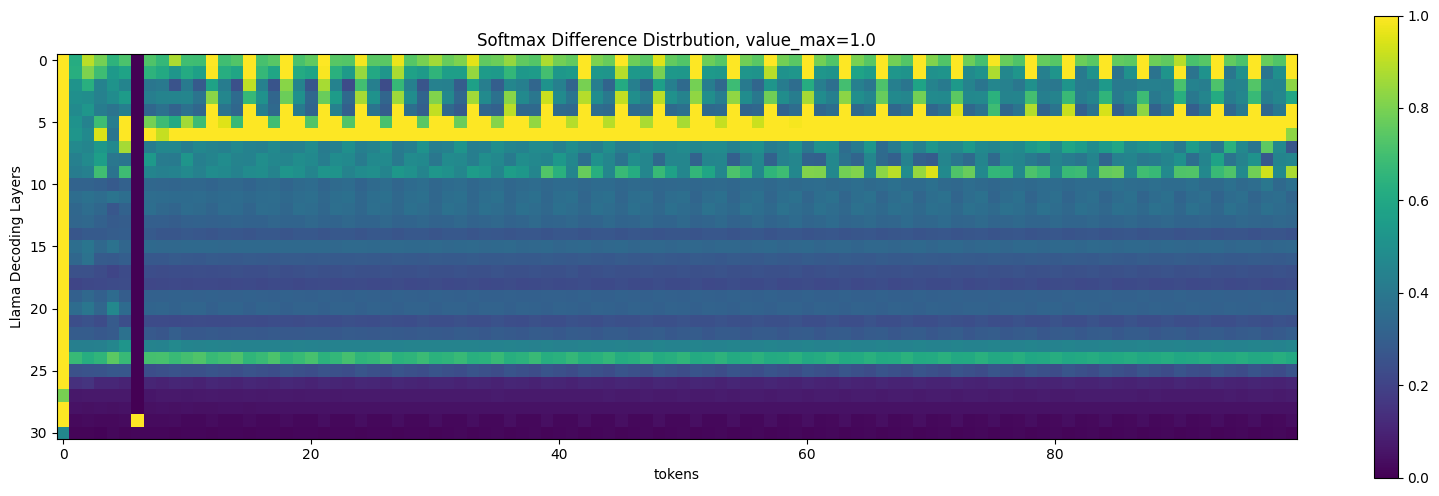

In [17]:
softmax_difference = model.model.all_softmax_diff
heatmap2d(torch.rot90(softmax_difference))

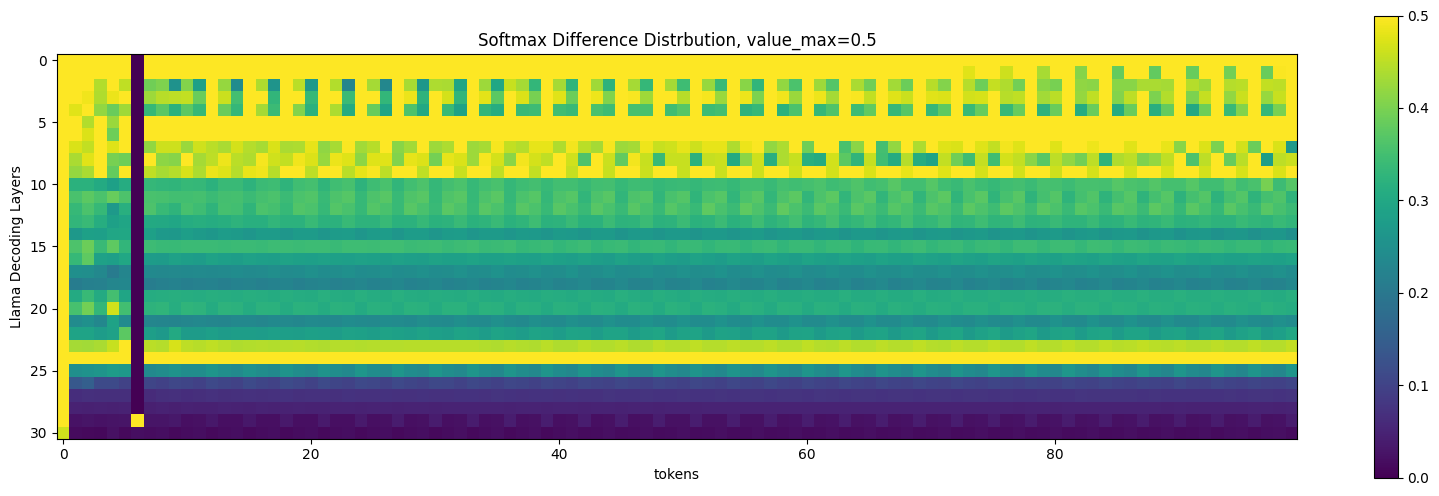

In [18]:
heatmap2d(torch.rot90(softmax_difference), value_max=0.5)

In [19]:
softmax_difference[20]

tensor([0.0187, 0.0210, 0.0486, 0.0721, 0.0983, 0.2352, 0.7090, 0.4426, 0.2847,
        0.2388, 0.3184, 0.3079, 0.2230, 0.2502, 0.2825, 0.3430, 0.2744, 0.3367,
        0.3577, 0.3640, 0.3523, 0.4512, 0.4731, 0.4810, 1.2842, 0.7295, 0.3215,
        0.3357, 0.2688, 0.5850, 0.7539], dtype=torch.float16)

In [20]:
# !huggingface-cli login

# model.push_to_hub(new_model, use_temp_dir=False)
# tokenizer.push_to_hub(new_model, use_temp_dir=False)